# Grid Search on Matrix Factorization

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

## Load MovieLens Small dataset

In [2]:
data = pd.read_csv(r"C:\Users\yineh\OneDrive\Masaüstü\ml-latest-small\ratings.csv", sep=",")

data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Check shape of data

In [3]:
data.shape

(100836, 4)

## Map user and movie IDs to unique consecutive indices starting from 0

In [4]:
user_ids = data['userId'].unique()
movie_ids = data['movieId'].unique()

user_mapping = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_mapping = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

data['userId'] = data['userId'].map(user_mapping)
data['movieId'] = data['movieId'].map(movie_mapping)

## Create the matrix factorization model

In [5]:
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=20):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.linear = nn.Linear(2*embedding_size, 1)

    def forward(self, X):
        user_embedding = self.user_embedding(X[:,0])
        movie_embedding = self.movie_embedding(X[:,1])
        prediction = torch.sum(user_embedding * movie_embedding, dim=1)
        return prediction

## Custom Dataset to use Dataloaders

In [6]:
class MovieLensDataset(Dataset):
    def __init__(self, dataframe):
        self.users = torch.tensor(dataframe['userId'].values, dtype=torch.long)
        self.movies = torch.tensor(dataframe['movieId'].values, dtype=torch.long)
        self.ratings = torch.tensor(dataframe['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return (self.users[idx], self.movies[idx]), self.ratings[idx]

## Define parameter for grid search

In [7]:
embedding_sizes = [5, 10, 20, 50]
learning_rates = [0.01, 0.03, 0.1, 0.001]
regularizations = [0, 0.001, 0.01, 0.1]

## Generate all combinations

In [8]:
param_grid = list(itertools.product(embedding_sizes, learning_rates, regularizations))

## Store Results

In [9]:
results = []

## Use gpu for calculations

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Split the data into training and test sets

In [11]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

## Prepare datasets and data loaders

In [14]:
batch_size = 8
train_dataset = MovieLensDataset(train_data)
test_dataset = MovieLensDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Loop over all combinations

In [15]:
for embedding_size, lr, reg in param_grid:
    num_users = len(user_ids)
    num_movies = len(movie_ids)
    model = MatrixFactorization(num_users, num_movies, embedding_size).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg)
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for (users, movies), ratings in train_loader:
            users = users.to(device)
            movies = movies.to(device)
            ratings = ratings.to(device)
            
            optimizer.zero_grad()
            outputs = model(torch.stack((users, movies), dim=1))
            loss = criterion(outputs, ratings)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_ratings = []
        for (users, movies), ratings in test_loader:
            users = users.to(device)
            movies = movies.to(device)
            ratings = ratings.to(device)
            
            outputs = model(torch.stack((users, movies), dim=1))
            all_preds.append(outputs.cpu())
            all_ratings.append(ratings.cpu())
        
        predictions = torch.cat(all_preds)
        y_test = torch.cat(all_ratings)
        test_mae = nn.L1Loss()(predictions, y_test).item()
        test_rmse = torch.sqrt(nn.MSELoss()(predictions, y_test)).item()
    results.append({
        'Embedding Size': embedding_size,
        'Learning Rate': lr,
        'Regularization': reg,
        'Test MAE': test_mae,
        'Test RMSE': test_rmse
    })
    
    print(f"Params: Embedding Size={embedding_size}, LR={lr}, Reg={reg}")
    print(f"Test MAE: {test_mae:.4f}, Test RMSE: {test_rmse:.4f}")

Params: Embedding Size=5, LR=0.01, Reg=0
Test MAE: 1.4049, Test RMSE: 1.9738
Params: Embedding Size=5, LR=0.01, Reg=0.001
Test MAE: 1.4842, Test RMSE: 1.8718
Params: Embedding Size=5, LR=0.01, Reg=0.01
Test MAE: 3.4891, Test RMSE: 3.6436
Params: Embedding Size=5, LR=0.01, Reg=0.1
Test MAE: 3.4926, Test RMSE: 3.6471
Params: Embedding Size=5, LR=0.03, Reg=0
Test MAE: 0.9395, Test RMSE: 1.3973
Params: Embedding Size=5, LR=0.03, Reg=0.001
Test MAE: 1.2241, Test RMSE: 1.5681
Params: Embedding Size=5, LR=0.03, Reg=0.01
Test MAE: 3.4737, Test RMSE: 3.6280
Params: Embedding Size=5, LR=0.03, Reg=0.1
Test MAE: 3.4926, Test RMSE: 3.6471
Params: Embedding Size=5, LR=0.1, Reg=0
Test MAE: 0.8386, Test RMSE: 1.2168
Params: Embedding Size=5, LR=0.1, Reg=0.001
Test MAE: 1.2350, Test RMSE: 1.5767
Params: Embedding Size=5, LR=0.1, Reg=0.01
Test MAE: 3.4394, Test RMSE: 3.5937
Params: Embedding Size=5, LR=0.1, Reg=0.1
Test MAE: 3.4926, Test RMSE: 3.6471
Params: Embedding Size=5, LR=0.001, Reg=0
Test MAE: 3

## Summarize Results

In [16]:
results_df = pd.DataFrame(results)
sorted_results = results_df.sort_values(by='Test MAE')
print("Top 10 configurations based on Test MAE:")
print(sorted_results.head(10))


Top 10 configurations based on Test MAE:
    Embedding Size  Learning Rate  Regularization  Test MAE  Test RMSE
8                5           0.10           0.000  0.838641   1.216823
24              10           0.10           0.000  0.903091   1.329257
4                5           0.03           0.000  0.939487   1.397295
20              10           0.03           0.000  0.993852   1.466649
40              20           0.10           0.000  1.009844   1.487505
36              20           0.03           0.000  1.123273   1.646108
56              50           0.10           0.000  1.200698   1.698178
21              10           0.03           0.001  1.220387   1.565979
37              20           0.03           0.001  1.220521   1.565471
53              50           0.03           0.001  1.222915   1.571309


## Visualizing the Results

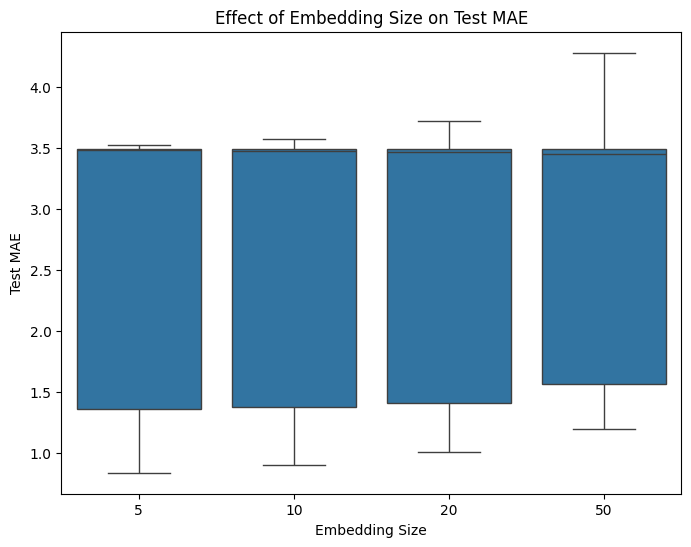

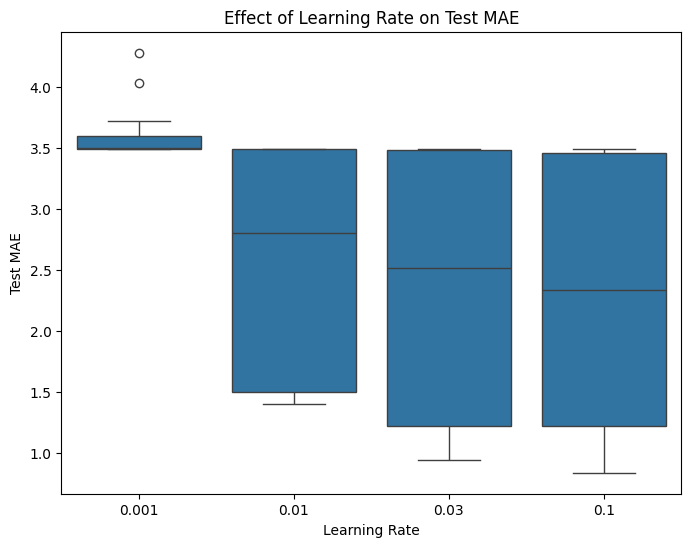

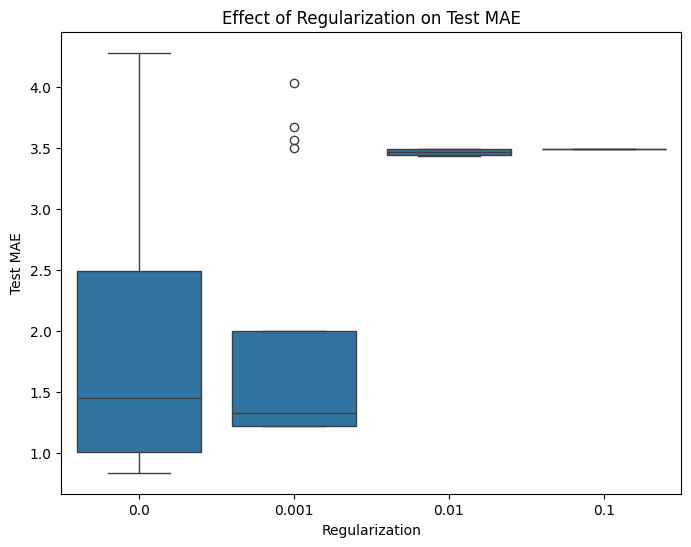

In [18]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Embedding Size', y='Test MAE', data=results_df)
plt.title('Effect of Embedding Size on Test MAE')
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(x='Learning Rate', y='Test MAE', data=results_df)
plt.title('Effect of Learning Rate on Test MAE')
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(x='Regularization', y='Test MAE', data=results_df)
plt.title('Effect of Regularization on Test MAE')
plt.show()